In [1]:
import os
import re
import numpy as np
import tensorflow as tf
from tensorflow.keras.layers import (
    Dense, Dropout, LayerNormalization, MultiHeadAttention, 
    Reshape, Flatten, Concatenate, Activation, Add, Input
)
from tensorflow.keras.models import Model  
from tensorflow.keras.callbacks import LearningRateScheduler, EarlyStopping, ReduceLROnPlateau, ModelCheckpoint
from tensorflow.keras.optimizers import AdamW
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.metrics import Precision, Recall
from tensorflow.keras.activations import gelu

from transformers import AutoTokenizer
from sentence_transformers import SentenceTransformer
import torch
import fitz
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
import matplotlib.pyplot as plt
from typing import List, Tuple

c:\Users\Salsa\PycharmProjects\endpoint\env-endpoint\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
# logging.basicConfig(level=logging.INFO)
# logger = logging.getLogger(__name__)

In [3]:
class TextProcessorWithPyMuPDF:
    def __init__(self, max_length=1024):
        self.model_name = "sentence-transformers/all-MiniLM-L6-v2"
        self.tokenizer = AutoTokenizer.from_pretrained(self.model_name)
        # Correctly initialize the sentence transformer
        self.sentence_transformer = SentenceTransformer(self.model_name)
        self.max_length = max_length
    
    def extract_from_pdf(self, pdf_path: str) -> str:
        """Extract text from PDF using PyMuPDF"""
        text = ""
        try:
            with fitz.open(pdf_path) as doc:
                for page in doc:
                    text += page.get_text() + "\n"
        except Exception as e:
            print(f"Error processing {pdf_path}: {str(e)}")
            return ""
        return text

    def clean_text(self, text: str) -> str:
        """Clean and normalize text"""
        text = re.sub(r'\s+', ' ', text)
        text = re.sub(r'\n+', ' ', text)
        text = re.sub(r'[^\w\s\-\'àáâãäåèéêëìíîïòóôõöùúûüýÿÀÁÂÃÄÅÈÉÊËÌÍÎÏÒÓÔÕÖÙÚÛÜÝ]', '', text)
        return text.strip()
    
    def hapus_duplikat(self, text: str) -> str:
        seen = set()
        result_text = []
        lines = text.split("\n")
        for line in lines:
            cleaned_line = line.strip()
            if cleaned_line and cleaned_line not in seen:
                seen.add(cleaned_line)
                result_text.append(cleaned_line)
        return "\n".join(result_text)
    
    def cut_isi(self, text: str) -> str:
        pola_2dapus = re.compile(r'(?<=daftar pustaka)(.*?)(?=daftar pustaka)', re.IGNORECASE)
        match = pola_2dapus.search(text)
        if match:
            hasil = match.group(1)
            return hasil
        else:
            pola_1dapus = re.compile(r'(.*?)(daftar pustaka)', re.IGNORECASE)
            cek_1dapus = pola_1dapus.search(text)
            if cek_1dapus:
                hasil = cek_1dapus.group(1)
                return hasil
            else:
                return "Tidak ditemukan kata 'daftar pustaka' sama sekali."

    def cut_daftar(self, text: str) -> str:
        pola_titik = re.compile(r'\.{10,}', re.DOTALL)
        matches = list(pola_titik.finditer(text))
        if matches:
            last_match = matches[-1]
            last_match_end = last_match.end()
            text = text[last_match_end:].strip()
        return text
    
    def generate_embeddings(self, texts, batch_size=32):
        """Generate embeddings for texts"""
        embeddings_list = []
        # Ensure texts is a list
        if isinstance(texts, str):
            texts = [texts]
        
        for i in range(0, len(texts), batch_size):
            batch = texts[i:i + batch_size]
            # Use encode method from sentence_transformer
            batch_embeddings = self.sentence_transformer.encode(batch, convert_to_tensor=True)
            embeddings_list.append(batch_embeddings)
        
        return torch.cat(embeddings_list, dim=0)
 
    def augment_text_methods(self, text: str) -> List[str]:
        """Text augmentation methods"""
        augmented = []
        
        # 1. Sentence shuffling
        sentences = text.split('. ')
        if len(sentences) > 1:
            shuffled = sentences.copy()
            np.random.shuffle(shuffled)
            augmented.append('. '.join(shuffled))
        
        # 2. Random deletion
        words = text.split()
        if len(words) > 10:
            n_to_delete = max(1, int(len(words) * 0.1))
            keep_indices = np.random.choice(
                len(words), 
                len(words) - n_to_delete, 
                replace=False
            )
            augmented.append(' '.join([words[i] for i in sorted(keep_indices)]))
            
        # 3. Random insertion
        if len(words) > 5:
            n_to_insert = max(1, int(len(words) * 0.1))
            augmented_words = words.copy()
            for _ in range(n_to_insert):
                pos = np.random.randint(0, len(words))
                word = np.random.choice(words)
                augmented_words.insert(pos, word)
            augmented.append(' '.join(augmented_words))
                
        return augmented

    def create_augmented_dataset(self, texts: List[str], n_augment: int = 2) -> List[str]:
        """Create augmented dataset"""
        augmented_texts = []
        
        for text in texts:
            # Keep original
            augmented_texts.append(text)
            
            # Add augmentations
            for _ in range(n_augment):
                augmented = self.augment_text_methods(text)
                if augmented:
                    augmented_texts.extend(augmented)
                    
        return augmented_texts

In [4]:
class FeynMindModelV3:
    def __init__(self, embedding_dim=384, dropout_rate=0.3, l2_regularization=1e-4):
        # Input layers
        text_input = Input(shape=(embedding_dim // 2,), name='text_input')
        explanation_input = Input(shape=(embedding_dim // 2,), name='explanation_input')
        
        # Initial normalization with improved epsilon
        text_norm = LayerNormalization(epsilon=1e-6)(text_input)
        explanation_norm = LayerNormalization(epsilon=1e-6)(explanation_input)
        
        # Reshape for attention
        text_reshaped = Reshape((1, embedding_dim // 2))(text_norm)
        explanation_reshaped = Reshape((1, embedding_dim // 2))(explanation_norm)
        
        # Self-attention blocks
        text_attention = MultiHeadAttention(num_heads=4, key_dim=embedding_dim // 8)(
            text_reshaped, text_reshaped
        )
        explanation_attention = MultiHeadAttention(num_heads=4, key_dim=embedding_dim // 8)(
            explanation_reshaped, explanation_reshaped
        )
        
        # Flatten attention outputs
        text_flat = Flatten()(text_attention)
        explanation_flat = Flatten()(explanation_attention)
        
        # Merge inputs with attention outputs
        x = Concatenate()([text_flat, explanation_flat])
        
        # First dense block with improved residual
        residual = x
        
        # Wider networks often perform better
        x = Dense(768, kernel_regularizer=tf.keras.regularizers.l2(l2_regularization))(x)
        x = LayerNormalization(epsilon=1e-6)(x)
        x = gelu(x)  # Using gelu directly instead of Activation layer
        x = Dropout(dropout_rate)(x)
        
        x = Dense(768, kernel_regularizer=tf.keras.regularizers.l2(l2_regularization))(x)
        x = LayerNormalization(epsilon=1e-6)(x)
        x = gelu(x)
        x = Dropout(dropout_rate)(x)
        
        # Residual connection with projection
        residual = Dense(768)(residual)
        x = Add()([x, residual])
        
        # Second dense block with gradual dimension reduction
        x = Dense(384, kernel_regularizer=tf.keras.regularizers.l2(l2_regularization))(x)
        x = LayerNormalization(epsilon=1e-6)(x)
        x = gelu(x)
        x = Dropout(dropout_rate)(x)
        
        # Task-specific heads with deeper architecture
        # Understanding branch
        understanding = Dense(256, activation='gelu')(x)
        understanding = LayerNormalization(epsilon=1e-6)(understanding)
        understanding = Dropout(0.2)(understanding)
        understanding = Dense(128, activation='gelu')(understanding)
        understanding = LayerNormalization(epsilon=1e-6)(understanding)
        understanding = Dropout(0.1)(understanding)
        understanding_output = Dense(3, activation='softmax', name='understanding')(understanding)
        
        # Completeness branch
        completeness = Dense(256, activation='gelu')(x)
        completeness = LayerNormalization(epsilon=1e-6)(completeness)
        completeness = Dropout(0.2)(completeness)
        completeness = Dense(128, activation='gelu')(completeness)
        completeness = LayerNormalization(epsilon=1e-6)(completeness)
        completeness = Dropout(0.1)(completeness)
        completeness_output = Dense(3, activation='softmax', name='completeness')(completeness)
        
        # Create model
        self.model = Model(
            inputs=[text_input, explanation_input],
            outputs=[understanding_output, completeness_output]
        )

    def compile_model(self, learning_rate=0.002):
        """Custom compilation with improved focal loss and label smoothing"""
        def focal_loss_with_smoothing(gamma=2.0, alpha=0.25, smoothing=0.1):
            def loss_fn(y_true, y_pred):
                epsilon = tf.keras.backend.epsilon()
                y_pred = tf.clip_by_value(y_pred, epsilon, 1. - epsilon)
                
                # Apply label smoothing
                n_classes = tf.cast(tf.shape(y_true)[-1], y_pred.dtype)
                y_true = y_true * (1.0 - smoothing) + (smoothing / n_classes)
                
                # Calculate focal loss
                ce = -y_true * tf.math.log(y_pred)
                weight = tf.pow(1 - y_pred, gamma) * y_true
                fl = alpha * weight * ce
                
                return tf.reduce_sum(fl, axis=-1)
            return loss_fn
        
        # Use AdamW with improved parameters
        optimizer = AdamW(
            learning_rate=learning_rate,
            weight_decay=1e-5,
            beta_1=0.9,
            beta_2=0.999,
            epsilon=1e-8,
            amsgrad=True
        )
        
        self.model.compile(
            optimizer=optimizer,
            loss={
                'understanding': focal_loss_with_smoothing(gamma=2.0, alpha=0.25, smoothing=0.1),
                'completeness': focal_loss_with_smoothing(gamma=2.0, alpha=0.25, smoothing=0.1)
            },
            metrics={
                'understanding': ['accuracy', Precision(name='precision'), Recall(name='recall')],
                'completeness': ['accuracy', Precision(name='precision'), Recall(name='recall')]
            }
        )

In [5]:
def load_and_preprocess_pdf_data(pdf_dir: str, augment: bool = True, n_augment: int = 2):
    """Load and preprocess PDF documents"""
    processor = TextProcessorWithPyMuPDF()
    all_texts = []
    
    # Check if directory exists
    if not os.path.exists(pdf_dir):
        raise ValueError(f"Directory {pdf_dir} does not exist")
    
    pdf_files = [f for f in os.listdir(pdf_dir) if f.endswith(".pdf")]
    
    # Check if there are any PDF files
    if not pdf_files:
        raise ValueError(f"No PDF files found in {pdf_dir}")
    
    for pdf_file in pdf_files:
        pdf_path = os.path.join(pdf_dir, pdf_file)
        try:
            raw_text = processor.extract_from_pdf(pdf_path)
            if raw_text:
                cleaned_text = processor.clean_text(raw_text)
                all_texts.append(cleaned_text)
        except Exception as e:
            print(f"Error processing {pdf_file}: {str(e)}")
            continue
    
    print(f"Successfully processed {len(all_texts)} documents")
    
    # Check if any texts were processed
    if not all_texts:
        raise ValueError("No text could be extracted from the PDFs")
    
    if augment:
        all_texts = processor.create_augmented_dataset(all_texts, n_augment)
        
    print(f"Total texts after augmentation: {len(all_texts)}")
    
    # Generate embeddings
    embeddings = processor.generate_embeddings(all_texts)
    embeddings_np = embeddings.cpu().numpy() if torch.cuda.is_available() else embeddings.numpy()
    
    # Split embeddings
    half_dim = embeddings_np.shape[1] // 2
    input_data = {
        "text_input": embeddings_np[:, :half_dim],
        "explanation_input": embeddings_np[:, half_dim:]
    }
    
    # Generate balanced labels
    n_samples = len(all_texts)
    labels = np.random.randint(0, 3, n_samples)
    
    # Balance classes
    from sklearn.utils import resample
    
    balanced_indices = []
    for i in range(3):
        indices = np.where(labels == i)[0]
        if len(indices) > 0:
            balanced_indices.extend(
                resample(indices, n_samples=max(len(indices), n_samples//3))
            )
    
    # Convert to categorical
    output_data = {
        "understanding": to_categorical(labels[balanced_indices], num_classes=3),
        "completeness": to_categorical(np.random.randint(0, 3, len(balanced_indices)), num_classes=3)
    }
    
    # Update input data
    for key in input_data:
        input_data[key] = input_data[key][balanced_indices]
        
    return input_data, output_data


In [6]:
def compute_class_weights(y):
    """
    Compute balanced class weights for training
    
    Args:
        y: One-hot encoded labels
        
    Returns:
        Dictionary mapping class indices to weights
    """
    # Convert one-hot to class indices
    y_indices = np.argmax(y, axis=1)
    
    # Get class counts
    classes = np.unique(y_indices)
    counts = np.bincount(y_indices)
    
    # Calculate weights
    n_samples = len(y_indices)
    n_classes = len(classes)
    
    weights = {}
    for i in range(n_classes):
        weights[i] = n_samples / (n_classes * counts[i])
        
    return weights

### Train Data

In [7]:
def train_model_v3(pdf_dir):
    # Load data
    input_data, output_data = load_and_preprocess_pdf_data(
        pdf_dir,
        augment=True,
        n_augment=2
    )
    
    # Split data with improved stratification
    combined_labels = np.argmax(output_data['understanding'], axis=1) * 3 + np.argmax(output_data['completeness'], axis=1)
    
    train_idx, val_idx = train_test_split(
        np.arange(input_data['text_input'].shape[0]), 
        test_size=0.15,
        stratify=combined_labels,
        random_state=42
    )
    
    # Prepare training and validation sets
    X_train = {
        'text_input': input_data['text_input'][train_idx],
        'explanation_input': input_data['explanation_input'][train_idx]
    }
    y_train = {
        'understanding': output_data['understanding'][train_idx],
        'completeness': output_data['completeness'][train_idx]
    }
    
    X_val = {
        'text_input': input_data['text_input'][val_idx],
        'explanation_input': input_data['explanation_input'][val_idx]
    }
    y_val = {
        'understanding': output_data['understanding'][val_idx],
        'completeness': output_data['completeness'][val_idx]
    }
    
    # Initialize model
    model = FeynMindModelV3(dropout_rate=0.3, l2_regularization=1e-4)
    
    # Modified loss functions to handle class weights internally
    def weighted_focal_loss(gamma=2.0, alpha=0.25, smoothing=0.1):
        def loss_fn(y_true, y_pred):
            epsilon = tf.keras.backend.epsilon()
            y_pred = tf.clip_by_value(y_pred, epsilon, 1. - epsilon)
            
            # Apply label smoothing
            n_classes = tf.cast(tf.shape(y_true)[-1], y_pred.dtype)
            y_true = y_true * (1.0 - smoothing) + (smoothing / n_classes)
            
            # Calculate sample weights based on class distribution
            class_counts = tf.reduce_sum(y_true, axis=0)
            total_samples = tf.reduce_sum(class_counts)
            class_weights = total_samples / (n_classes * class_counts + epsilon)
            sample_weights = tf.reduce_sum(y_true * class_weights, axis=1)
            
            # Calculate focal loss
            ce = -y_true * tf.math.log(y_pred)
            weight = tf.pow(1 - y_pred, gamma) * y_true
            fl = alpha * weight * ce * tf.expand_dims(sample_weights, -1)
            
            return tf.reduce_sum(fl, axis=-1)
        return loss_fn
    
    # Define initial learning rate
    initial_learning_rate = 0.002
    
    # Custom learning rate schedule with warmup
    def lr_schedule(epoch):
        if epoch < 10:  # Warmup period
            return initial_learning_rate * min(1., epoch / 10.)
        return initial_learning_rate * 0.7 ** (epoch // 7)  # Decay after warmup
    
    # Compile with modified loss functions
    optimizer = AdamW(
        learning_rate=initial_learning_rate,
        weight_decay=1e-5,
        beta_1=0.9,
        beta_2=0.999,
        epsilon=1e-8,
        amsgrad=True
    )
    
    model.model.compile(
        optimizer=optimizer,
        loss={
            'understanding': weighted_focal_loss(gamma=2.0, alpha=0.25, smoothing=0.1),
            'completeness': weighted_focal_loss(gamma=2.0, alpha=0.25, smoothing=0.1)
        },
        metrics={
            'understanding': ['accuracy', Precision(name='precision'), Recall(name='recall')],
            'completeness': ['accuracy', Precision(name='precision'), Recall(name='recall')]
        }
    )
    
    # Enhanced callbacks
    callbacks = [
        EarlyStopping(
            monitor='val_loss',
            patience=25,
            restore_best_weights=True,
            min_delta=1e-4
        ),
        ReduceLROnPlateau(
            monitor='val_loss',
            factor=0.7,
            patience=7,
            min_lr=1e-6,
            verbose=1
        ),
        ModelCheckpoint(
            'feynmind_model_v3.keras',
            monitor='val_loss',
            save_best_only=True,
            save_weights_only=False
        ),
        LearningRateScheduler(lr_schedule)
    ]
    
    # Train model
    history = model.model.fit(
        x=X_train,
        y=y_train,
        validation_data=(X_val, y_val),
        epochs=200,
        batch_size=32,
        callbacks=callbacks,
        verbose=1
    )
    
    return model, history

In [8]:
# # Calculate class weights for balancing
# class_weights = class_weight.compute_class_weight(
#     class_weight='balanced',
#     classes=np.unique(np.argmax(y_train['understanding'], axis=1)),
#     y=np.argmax(y_train['understanding'], axis=1)
# )
# class_weights = {i: w for i, w in enumerate(class_weights)}

# # Create data pipelines with augmentation and class balancing
# train_data = create_data_pipeline(X_train, y_train, batch_size=16, augment=True, num_augmented=1)
# val_data = create_data_pipeline(X_val, y_val, batch_size=16)

In [9]:

def main():
    pdf_dir = "Perkategori/"
    model, history = train_model_v3(pdf_dir)
    
    # Save model
    # model.model.save('similarity_model_2.h5')
    model.model.export("saved_model")
    
    # Plot training history
    plt.figure(figsize=(12, 4))
    
    plt.subplot(1, 2, 1)
    plt.plot(history.history['understanding_accuracy'], label='Understanding (Train)')
    plt.plot(history.history['val_understanding_accuracy'], label='Understanding (Val)')
    plt.title('Understanding Accuracy')
    plt.legend()
    
    plt.subplot(1, 2, 2)
    plt.plot(history.history['completeness_accuracy'], label='Completeness (Train)')
    plt.plot(history.history['val_completeness_accuracy'], label='Completeness (Val)')
    plt.title('Completeness Accuracy')
    plt.legend()
    
    plt.tight_layout()
    plt.savefig('training_history.png')
    plt.close()
    
    return model, history

In [10]:
if __name__ == "__main__":
    model, history = main()

Successfully processed 38 documents
Total texts after augmentation: 190
Epoch 1/200
6/6 ━━━━━━━━━━━━━━━━━━━━ 13s 317ms/step - completeness_accuracy: 0.2840 - completeness_loss: 0.2473 - completeness_precision: 0.2911 - completeness_recall: 0.2213 - loss: 0.7068 - understanding_accuracy: 0.3692 - understanding_loss: 0.2871 - understanding_precision: 0.4092 - understanding_recall: 0.3501 - val_completeness_accuracy: 0.3793 - val_completeness_loss: 0.2516 - val_completeness_precision: 0.3571 - val_completeness_recall: 0.3448 - val_loss: 0.9890 - val_understanding_accuracy: 0.3448 - val_understanding_loss: 0.5583 - val_understanding_precision: 0.3448 - val_understanding_recall: 0.3448 - learning_rate: 0.0000e+00
Epoch 2/200
6/6 ━━━━━━━━━━━━━━━━━━━━ 1s 98ms/step - completeness_accuracy: 0.3431 - completeness_loss: 0.2259 - completeness_precision: 0.3659 - completeness_recall: 0.2880 - loss: 0.6932 - understanding_accuracy: 0.3269 - understanding_loss: 0.2913 - understanding_precision: 0.317

INFO:tensorflow:Assets written to: saved_model\assets


Saved artifact at 'saved_model'. The following endpoints are available:

* Endpoint 'serve'
  args_0 (POSITIONAL_ONLY): List[TensorSpec(shape=(None, 192), dtype=tf.float32, name='text_input'), TensorSpec(shape=(None, 192), dtype=tf.float32, name='explanation_input')]
Output Type:
  List[TensorSpec(shape=(None, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None, 3), dtype=tf.float32, name=None)]
Captures:
  2688970744144: TensorSpec(shape=(), dtype=tf.resource, name=None)
  2688972468688: TensorSpec(shape=(), dtype=tf.resource, name=None)
  2688972470032: TensorSpec(shape=(), dtype=tf.resource, name=None)
  2688970742032: TensorSpec(shape=(), dtype=tf.resource, name=None)
  2688970744528: TensorSpec(shape=(), dtype=tf.resource, name=None)
  2688970741072: TensorSpec(shape=(), dtype=tf.resource, name=None)
  2688970741840: TensorSpec(shape=(), dtype=tf.resource, name=None)
  2688970740112: TensorSpec(shape=(), dtype=tf.resource, name=None)
  2688970740688: TensorSpec(shape=(), dtyp

In [19]:
model.save('similarity_model_2.h5')

AttributeError: 'FeynMindModelV3' object has no attribute 'save'

In [14]:
import time
saved_model_path = "./{}.h5".format(int(time.time()))

model.save(saved_model_path)

In [ ]:
import os
import tensorflowjs as tfjs
import tensorflow as tf

try:
    # Validate model path
    model_path = os.path.abspath('C:/Users/Salsa/PycharmProjects/pytorch/similarity_model.h5')
    if not os.path.exists(model_path):
        raise FileNotFoundError(f"Model file not found: {model_path}")
        
    output_dir = './web_model'
    
    # Create output directory
    os.makedirs(output_dir, exist_ok=True)
    
    # Load and verify model
    model = tf.keras.models.load_model(model_path)
    
    # Convert model using tfjs API
    tfjs.converters.save_keras_model(model, output_dir)
    print(f"Model converted successfully to {os.path.abspath(output_dir)}")

except FileNotFoundError as e:
    print(f"Error: {e}")
except Exception as e:
    print(f"Conversion failed: {str(e)}")
finally:
    # Cleanup any temporary files if needed
    print("Conversion process completed")

NotFoundError: c:\Users\Salsa\PycharmProjects\pytorch\.venv\Lib\site-packages\tensorflow_decision_forests\tensorflow\ops\inference\inference.so not found

In [20]:
import tensorflowjs as tfjs

!tensorflowjs_converter --input_format=keras {C:/Users/Salsa/PycharmProjects/pytorch/similarity_model.h5} ./

NotFoundError: c:\Users\Salsa\PycharmProjects\pytorch\.venv\Lib\site-packages\tensorflow_decision_forests\tensorflow\ops\inference\inference.so not found

In [19]:
from typing import Dict

class QuestionEvaluator:
    def __init__(self, model, processor):
        self.model = model
        self.processor = processor
    
    def prepare_input_data(self, student_explanation: str, reference_pdf_path: str) -> Dict[str, np.ndarray]:
        # Clean and process texts
        cleaned_explanation = self.processor.clean_text(student_explanation)
        reference_text = self.processor.extract_from_pdf(reference_pdf_path)
        cleaned_reference = self.processor.clean_text(reference_text)
        
        # Generate embeddings
        explanation_emb = self.processor.generate_embeddings(cleaned_explanation)
        reference_emb = self.processor.generate_embeddings(cleaned_reference)
        
        # Convert to numpy
        explanation_emb_np = explanation_emb.cpu().numpy() if torch.cuda.is_available() else explanation_emb.numpy()
        reference_emb_np = reference_emb.cpu().numpy() if torch.cuda.is_available() else reference_emb.numpy()
        
        # Ensure correct shape for model input
        if len(explanation_emb_np.shape) == 1:
            explanation_emb_np = np.expand_dims(explanation_emb_np, 0)
        if len(reference_emb_np.shape) == 1:
            reference_emb_np = np.expand_dims(reference_emb_np, 0)
            
        # Split embeddings
        half_dim = explanation_emb_np.shape[1] // 2
        return {
            "text_input": reference_emb_np[:, :half_dim],
            "explanation_input": explanation_emb_np[:, half_dim:]
        }
    
    def evaluate_explanation(self, student_explanation: str, reference_pdf_path: str) -> Dict[str, Dict[str, float]]:
        input_data = self.prepare_input_data(student_explanation, reference_pdf_path)
        
        # Get predictions using model's predict method
        predictions = self.model.model.predict([
            input_data['text_input'],
            input_data['explanation_input']
        ])
        
        # Convert predictions to probabilities
        understanding_pred = predictions[0]
        completeness_pred = predictions[1]
        
        # Format results with confidence scores
        results = {
            "understanding": {
                "Low": float(understanding_pred[0][0]),
                "Medium": float(understanding_pred[0][1]), 
                "High": float(understanding_pred[0][2])
            },
            "completeness": {
                "Incomplete": float(completeness_pred[0][0]),
                "Partial": float(completeness_pred[0][1]),
                "Complete": float(completeness_pred[0][2])
            },
            "metrics": {
                "understanding_confidence": float(np.max(understanding_pred)),
                "completeness_confidence": float(np.max(completeness_pred))
            }
        }
        
        return results
    
    def bulk_evaluate(self, explanations_dir: str, references_dir: str) -> List[Dict]:
        evaluation_results = []
        
        txt_files = [f for f in os.listdir(explanations_dir) if f.endswith('.txt')]
        pdf_files = [f for f in os.listdir(references_dir) if f.endswith('.pdf')]
        
        for txt_file in txt_files:
            base_name = os.path.splitext(txt_file)[0]
            matching_pdf = f"{base_name}.pdf"  # Changed from .txt to .pdf
            
            if matching_pdf in pdf_files:
                txt_path = os.path.join(explanations_dir, txt_file)
                pdf_path = os.path.join(references_dir, matching_pdf)
                
                with open(txt_path, 'r', encoding='utf-8') as f:
                    student_explanation = f.read()
                
                try:
                    result = self.evaluate_explanation(student_explanation, pdf_path)
                    result['filename'] = txt_file
                    evaluation_results.append(result)
                except Exception as e:
                    print(f"Error evaluating {txt_file}: {e}")
        
        return evaluation_results

def visualize_evaluation_results(results: List[Dict]):
    """Enhanced visualization with confidence metrics"""
    plt.figure(figsize=(15, 5))
    
    # Understanding scores
    plt.subplot(1, 3, 1)
    understanding_scores = [r['understanding']['High'] for r in results]
    plt.hist(understanding_scores, bins=10, color='blue', alpha=0.7)
    plt.title('Understanding Scores')
    plt.xlabel('High Understanding Probability')
    plt.ylabel('Frequency')
    
    # Completeness scores
    plt.subplot(1, 3, 2)
    completeness_scores = [r['completeness']['Complete'] for r in results]
    plt.hist(completeness_scores, bins=10, color='green', alpha=0.7)
    plt.title('Completeness Scores')
    plt.xlabel('Complete Score Probability')
    plt.ylabel('Frequency')
    
    # Confidence metrics
    plt.subplot(1, 3, 3)
    confidence_u = [r['metrics']['understanding_confidence'] for r in results]
    confidence_c = [r['metrics']['completeness_confidence'] for r in results]
    plt.boxplot([confidence_u, confidence_c], labels=['Understanding', 'Completeness'])
    plt.title('Prediction Confidence')
    plt.ylabel('Confidence Score')
    
    plt.tight_layout()
    plt.show()

In [41]:
def setup_evaluator(model_path=None):
    """
    Set up the QuestionEvaluator with a trained model
    
    Args:
        model_path (str, optional): Path to saved model weights
    
    Returns:
        QuestionEvaluator instance
    """
    # Initialize processor and model
    processor = TextProcessorWithPyMuPDF()
    model = FeynMindModelV2()
    
    # Load pre-trained weights if path provided
    if model_path and os.path.exists(model_path):
        model.model.load_weights(model_path)
    
    # Create evaluator
    evaluator = QuestionEvaluator(model, processor)
    
    return evaluator

def main_evaluation():
    """
    Main function to demonstrate evaluation process
    """
    # Set up evaluator
    evaluator = setup_evaluator()
    
    # Example usage for single explanation
    student_explanation = "Pada bab *Menjelajah Sel*, terdapat beberapa poin penting yang perlu dipahami. Pada *Aktivitas 1.1*, objek yang tidak dapat diamati dengan mikroskop cahaya meliputi virus T2 fag, protein, lipid, molekul-molekul kecil, dan atom. Sebaliknya, objek yang dapat diamati mencakup telur ikan, burung kolibri, manusia, paus biru, dan pohon pinus raksasa. Pada *Aktivitas 1.2*, saya membaca artikel berjudul *Pemeriksaan Sitologi Aspiratif untuk Mendeteksi Kanker Paru*. Artikel ini menjelaskan bahwa para peneliti menggunakan berbagai metode dalam penelitian sitologi untuk mendukung deteksi kanker paru.  Pada *Aktivitas 1.3*, jenis-jenis mikroskop juga dipelajari. Mikroskop cahaya mampu memperbesar hingga 1.000 kali, sementara mikroskop elektron memiliki kemampuan hingga 1.000.000 kali. Namun, perbesaran maksimal pada mikroskop elektron sering kali sulit tercapai karena berbagai faktor teknis. Di *Aktivitas 1.4*, kita mengenal bagian-bagian mikroskop dan fungsinya. Misalnya, lensa okuler berfungsi memperbesar bayangan dari lensa objektif, tabung menghubungkan kedua lensa tersebut, sementara sekrup pengarah kasar dan halus digunakan untuk mengatur fokus dengan tingkat kecepatan yang berbeda. Ada juga revolver yang digunakan untuk mengganti perbesaran lensa objektif, serta meja benda yang menjadi tempat meletakkan preparat.  Selanjutnya, pada *Aktivitas 1.7*, dibahas enam jenis sel yang mendukung retina mata, yaitu sel fotoreseptor, sel bipolar, sel ganglion retina, sel horizontal, sel amakrin, dan sel pigmen retina. Masing-masing sel memiliki peran khusus dalam memastikan fungsi retina berjalan optimal. Selain itu, penting untuk memahami cara memegang, menyimpan, dan menggunakan mikroskop dengan benar. Mikroskop sebaiknya dipegang dengan tangan kanan pada bagian pegangan, sementara tangan kiri menopang di bawahnya, dan disimpan di tempat yang aman serta kering untuk menjaga keawetannya. Demikian penjelasan mengenai materi ini."
    reference_pdf_path = "Perkategori/Biologi-BG-KLS-XI-29-50.pdf"
    
    single_result = evaluator.evaluate_explanation(
        student_explanation, 
        reference_pdf_path
    )
    print("Single Explanation Evaluation:")
    print(single_result)
    
    # Bulk evaluation
    bulk_results = evaluator.bulk_evaluate(
        explanations_dir="Penjelasan/", 
        references_dir="Perkategori/"
    )
    print("\nBulk Evaluation Results:")
    for result in bulk_results:
        print(result)

# Optional: Add visualization for results
def visualize_evaluation_results(results):
    """
    Visualize evaluation results
    
    Args:
        results (List[Dict]): Evaluation results from bulk_evaluate
    """
    import matplotlib.pyplot as plt
    
    understanding_scores = [
        result['understanding']['High'] for result in results
    ]
    completeness_scores = [
        result['completeness']['Complete'] for result in results
    ]
    
    plt.figure(figsize=(10, 5))
    
    plt.subplot(1, 2, 1)
    plt.hist(understanding_scores, bins=10, color='blue', alpha=0.7)
    plt.title('Distribution of Understanding Scores')
    plt.xlabel('High Understanding Probability')
    plt.ylabel('Frequency')
    
    plt.subplot(1, 2, 2)
    plt.hist(completeness_scores, bins=10, color='green', alpha=0.7)
    plt.title('Distribution of Completeness Scores')
    plt.xlabel('Complete Explanation Probability')
    plt.ylabel('Frequency')
    
    plt.tight_layout()
    plt.show()

In [42]:

if __name__ == "__main__":
    main_evaluation()

c:\Users\Salsa\PycharmProjects\pytorch\.venv\Lib\site-packages\keras\src\models\functional.py:225: UserWarning: The structure of `inputs` doesn't match the expected structure: ['text_input', 'explanation_input']. Received: the structure of inputs=('*', '*')
  warnings.warn(


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 334ms/step
Single Explanation Evaluation:
{'understanding': {'Low': 0.3131571114063263, 'Medium': 0.29885348677635193, 'High': 0.3879894018173218}, 'completeness': {'Incomplete': 0.054081209003925323, 'Partial': 0.8973579406738281, 'Complete': 0.04856080934405327}, 'metrics': {'understanding_confidence': 0.3879894018173218, 'completeness_confidence': 0.8973579406738281}}

Bulk Evaluation Results:


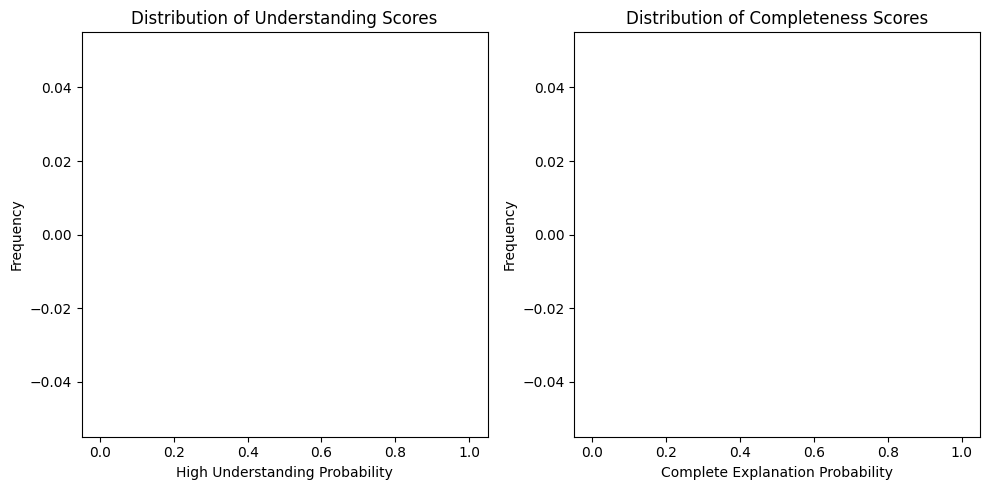

In [45]:

visualize_evaluation_results(setup_evaluator().bulk_evaluate("Penjelasan/", "Perkategori/"))